# Predicting survival on the titanic

In [3]:
import pandas as pd
import numpy as np
import csv

import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv('train.csv', header=0)
df_test = pd.read_csv('test.csv', header=0)

First, let's take a look at our data.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Next, let's visualise some basic information about the passengers.

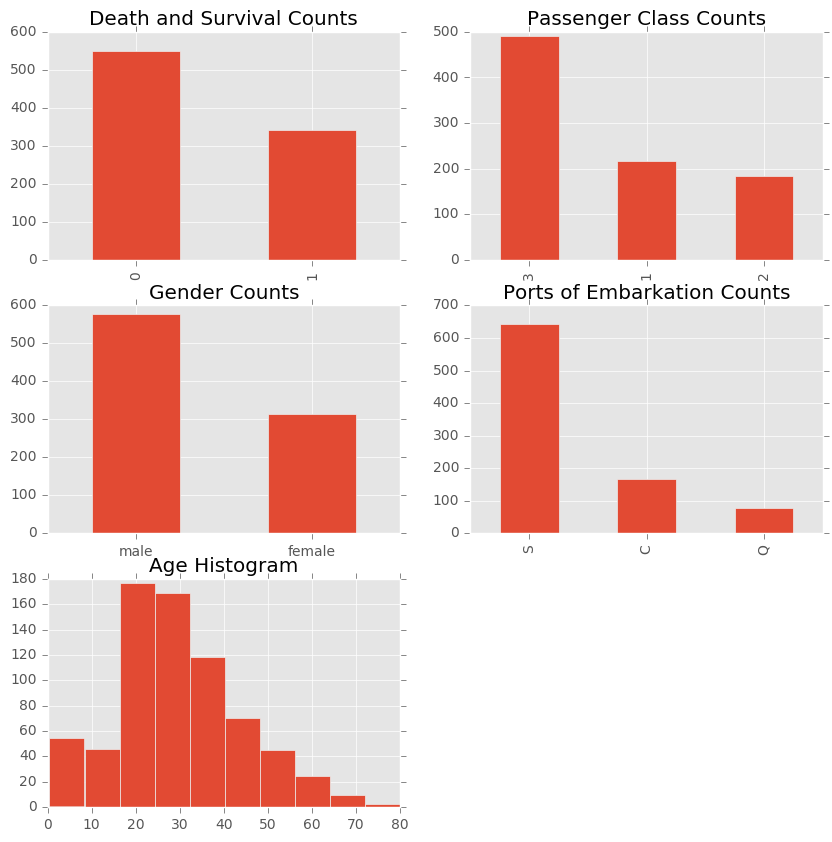

In [5]:
plt.style.use("ggplot")
# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(10, 5))
# Size of matplotlib figures that contain subplots
figsize_with_subplots = (10, 10)
# Size of matplotlib histogram bins
bin_size = 10
fig = plt.figure(figsize=figsize_with_subplots) 
fig_dims = (3, 2)
# Plot death and survival counts
plt.subplot2grid(fig_dims, (0, 0))
df['Survived'].value_counts().plot(kind='bar', title='Death and Survival Counts')
# Plot Pclass counts
plt.subplot2grid(fig_dims, (0, 1))
df['Pclass'].value_counts().plot(kind='bar', title='Passenger Class Counts')
# Plot Sex counts
plt.subplot2grid(fig_dims, (1, 0))
df['Sex'].value_counts().plot(kind='bar', title='Gender Counts')
plt.xticks(rotation=0)
# Plot Embarked counts
plt.subplot2grid(fig_dims, (1, 1))
df['Embarked'].value_counts().plot(kind='bar', title='Ports of Embarkation Counts')
# Plot the Age histogram
plt.subplot2grid(fig_dims, (2, 0))
df['Age'].hist()
plt.title('Age Histogram')

Now let's encode some features.

In [6]:
df['Gender'] = df['Sex'].map( {'female':0, 'male':1} ).astype(int)
df['PortCode'] = df['Embarked'].dropna()
df['PortCode'] = df['Embarked'].dropna().map( {'C':0, 'S':1, 'Q':2}).astype(int)

Look at the absolute numbers and percentages of survival among men and women.

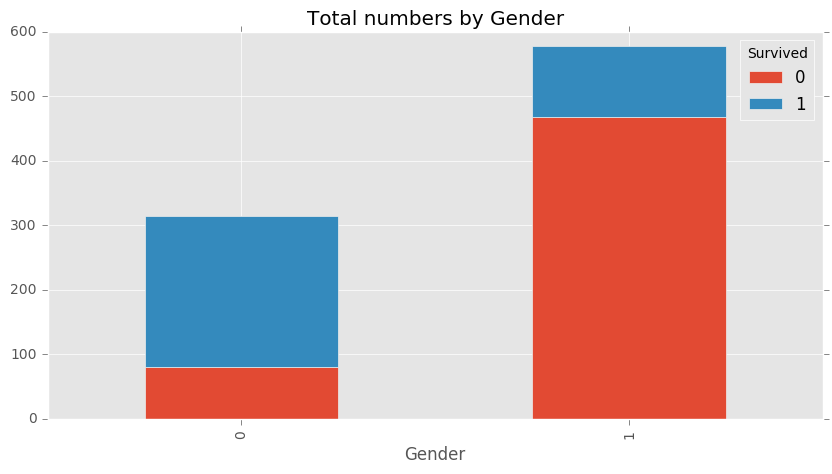

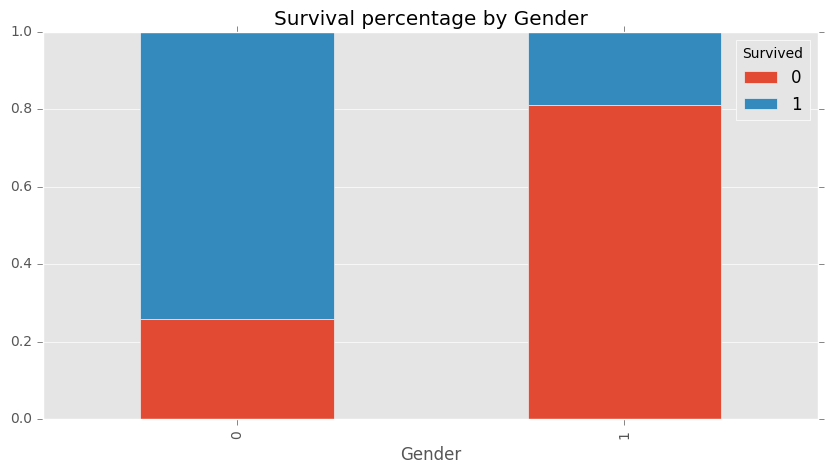

In [7]:
gender_survival = pd.crosstab(df['Gender'], df['Survived'])
gender_survival_percent = gender_survival.div(gender_survival.sum(1).astype(float), axis=0)
gender_survival.plot(kind='bar', stacked=True, title='Total numbers by Gender')
gender_survival_percent.plot(kind='bar', stacked=True, title='Survival percentage by Gender')

Now let's look at the same thing among passengers belonging to different socio-economic strata.

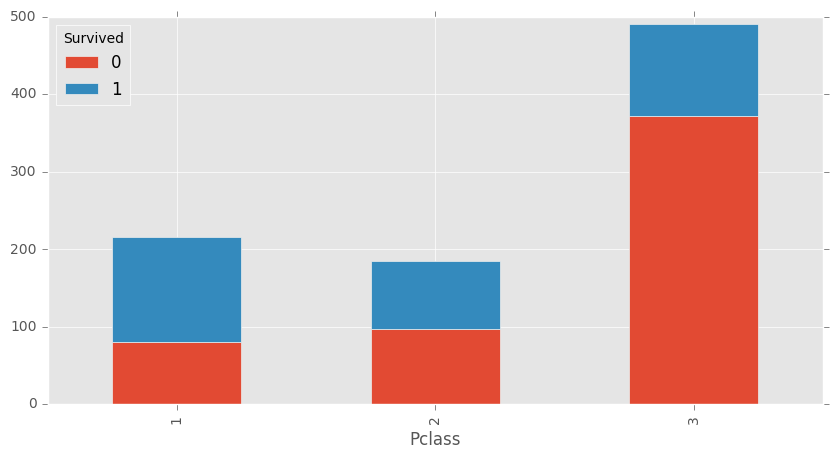

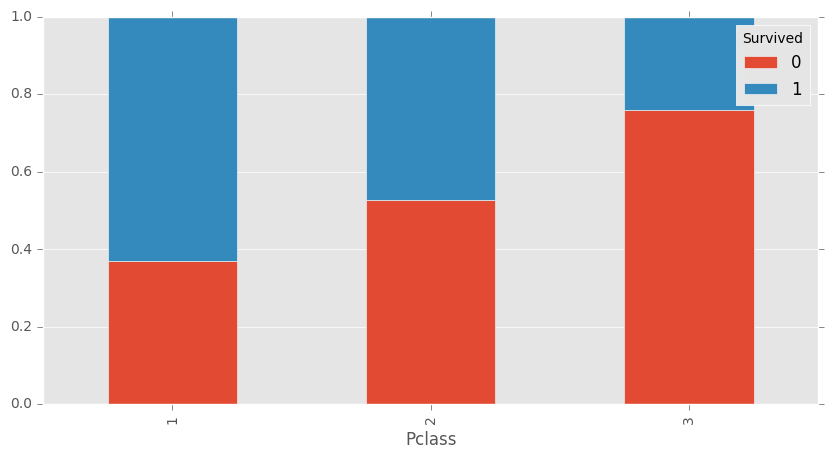

In [8]:
class_survival = pd.crosstab(df['Pclass'], df['Survived'])
class_survival.plot(kind="bar", stacked=True)
class_survival_percent = class_survival.div(class_survival.sum(1).astype(float), axis=0)
class_survival_percent.plot(kind="bar", stacked=True)

There are two passengers with unknown Embarkation ports.

In [9]:
df[df.PortCode.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,PortCode
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0,NaN


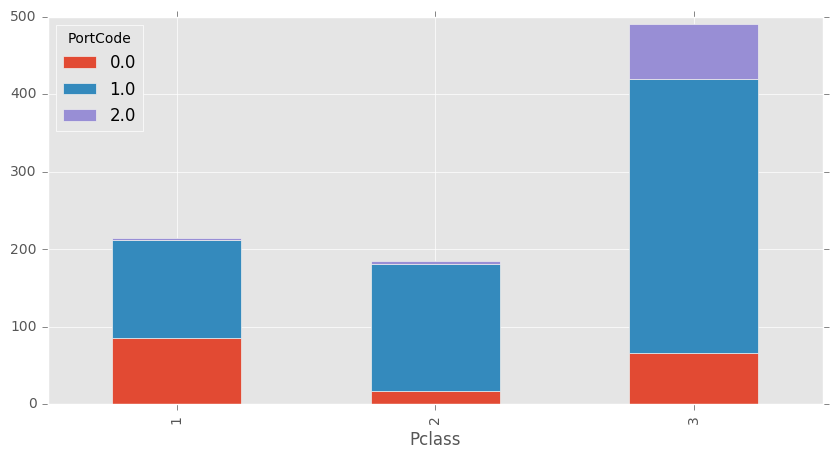

In [10]:
class_embarked = pd.crosstab(df.Pclass, df.PortCode)
class_embarked.plot(kind="Bar", stacked=True)

Since the majority of people in passenger class 1 boarded the ship at the port encoded with "1", and the two passangers with unknown embarkation ports belong to passenger class 1, let's set both unknown PortCodes to 1.

In [11]:
df.loc[df.PortCode.isnull(), "PortCode"] = 1

Now let's get the median age of the passengers for all genders, passenger classes, and ports of origin.

In [12]:
median_ages = np.zeros((2,3,3))
for i in range(0, 2):
    for j in range(0,3):
        for k in range(0,3):
            median_ages[i,j,k] = df[(df['Gender'] == i) & (df['Pclass'] == j+1) & (df['PortCode'] == k)]['Age'].dropna().median()
median_ages

array([[[ 37.  ,  34.  ,  33.  ],
        [ 22.  ,  29.  ,  30.  ],
        [ 14.25,  23.  ,  20.  ]],

       [[ 36.5 ,  42.  ,  44.  ],
        [ 29.5 ,  30.  ,  57.  ],
        [ 26.  ,  25.  ,  27.  ]]])

And use that information to fill in the appropriate result for each passenger with a missing age.

In [13]:
df['Agefill'] = df['Age']
for i in range(0, 2):
    for j in range(0,3):
        for k in range(0,3):
            df.loc[ (df.Age.isnull()) & (df.Gender == i) & (df.Pclass == j+1) & (df.PortCode == k), 'Agefill'] = median_ages[i, j, k]
df[ df['Age'].isnull() ][["Gender", "Pclass", "Age", "Agefill"]].head(10)

,Gender,Pclass,Age,Agefill
5,1,3,NaN,27.00
17,1,2,NaN,30.00
19,0,3,NaN,14.25
26,1,3,NaN,26.00
28,0,3,NaN,20.00
29,1,3,NaN,25.00
31,0,1,NaN,37.00
32,0,3,NaN,20.00
36,1,3,NaN,26.00
42,1,3,NaN,26.00


## Feature engineering

In [14]:
df['FamilySize'] = df["Parch"]+df['SibSp']
df['Agefill*Pclass'] = df.Agefill * df.Pclass
titles = ["Dr.", "Don.", "General", "Colonel", "Captain", "Count", "Countess", "Jonkheer", "Lord", "Master.", "Sir.", "Mlle.",
         "Cpt.", "Major.", "Col.", "Mme", "Lady."]
df['Title'] = 0
for title in titles:
    df.loc[(df['Name'].str.contains(title, regex=False)), 'Title'] = 1

Drop the features we're not going to use.

In [15]:
df = df.drop(["Name", "Sex", "Ticket", "Cabin", "Embarked", "Age", "PassengerId"], axis=1)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived          891 non-null int64
Pclass            891 non-null int64
SibSp             891 non-null int64
Parch             891 non-null int64
Fare              891 non-null float64
Gender            891 non-null int32
PortCode          891 non-null float64
Agefill           891 non-null float64
FamilySize        891 non-null int64
Agefill*Pclass    891 non-null float64
Title             891 non-null int64
dtypes: float64(4), int32(1), int64(6)
memory usage: 80.1 KB


In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Repeat everything we did so far on df_test.

In [17]:
df_test['Gender'] = df_test['Sex'].map(lambda x: x[0].upper())
df_test['Gender'] = df_test['Sex'].map( {'female':0, 'male':1} ).astype(int)

df_test['PortCode'] = df_test['Embarked'].dropna()
df_test['PortCode'] = df_test['Embarked'].dropna().map( {'C':0, 'S':1, 'Q':2}).astype(float)
df_test['Agefill'] = df_test["Age"]
for i in range(0, 2):
    for j in range(0,3):
        for k in range(0,3):
            median_ages[i,j,k] = df_test[(df_test['Gender'] == i) & (df_test['Pclass'] == j+1) & (df_test['PortCode'] == k)]['Age'].dropna().median()

for i in range(0, 2):
    for j in range(0,3):
        for k in range(0,3):
            df_test.loc[ (df_test.Age.isnull()) & (df_test.Gender == i) & (df_test.Pclass == j+1) & (df_test.PortCode == k), 'Agefill'] = median_ages[i, j, k]

df_test['FamilySize'] = df_test["Parch"]+df_test['SibSp']
df_test['Agefill*Pclass'] = df_test.Agefill * df_test.Pclass
df_test['Title'] = 0
for title in titles:
    df_test.loc[(df_test['Name'].str.contains(title, regex=False)), 'Title'] = 1
ids = df_test['PassengerId'].values

df_test.insert(0, 'Survived', -1)
df_test = df_test.drop(["Name", "Sex", "Ticket", "Cabin", "Embarked", "Age", "PassengerId"], axis=1)

Fill in the unknown fare.

In [18]:
df_test[df_test.Fare.isnull()]

,Survived,Pclass,SibSp,Parch,Fare,Gender,PortCode,Agefill,FamilySize,Agefill*Pclass,Title
152,-1,3,0,0,NaN,1,1.0,60.5,0,181.5,0


In [19]:
df_test[(df_test.Pclass) == 3 & (df_test.Gender == 1)].Fare.median()

51.8625

In [20]:
df_test.Fare[152] = 51.8625

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## Testing model

It's important to split your data into training, testing, and validation sets, so let's do just that.

In [21]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.4, random_state=0)
test, validate = train_test_split(test, test_size=0.5, random_state=0)

Convert the existing dataframes into numpy arrays.

In [22]:
train_data = train.values
test_data = test.values
validate_data = validate.values

Use the Pipeline function along with GridSearchCV to find out the best parameters for the algorithm you're using.
Here I'm using SVC, but this method can easily be applied to other algorithms.

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(train_data[0::,1::], train_data[0::,0])
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(test_data[0::,1::], test_data[0::,0])))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.84
Test set score: 0.81
Best parameters: {'svm__C': 100, 'svm__gamma': 0.1}
